BiLSTM MODEL

In [110]:
!git clone https://github.com/alean23/EC523Project.git
%cd EC523Project

Cloning into 'EC523Project'...
remote: Enumerating objects: 130, done.
remote: Counting objects: 100% (83/83), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 130 (delta 45), reused 67 (delta 34), pack-reused 47 (from 1)
Receiving objects: 100% (130/130), 74.84 MiB | 30.35 MiB/s, done.
Resolving deltas: 100% (72/72), done.
Updating files: 100% (76/76), done.
/content/EC523Project/EC523Project/EC523Project/EC523Project/EC523Project/EC523Project/EC523Project


In [120]:
# Import libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout, LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from sklearn.metrics import f1_score
from tensorflow.keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt

In [112]:
# Load data from cloned repository
data = pd.read_csv('final_combined_with_team_records.csv').fillna(0)
print(f"Data loaded successfully. Shape: {data.shape}")

Data loaded successfully. Shape: (3040, 88)


In [113]:
# Tokenize player names
player_name_columns = [col for col in data.columns if 'player' in col and 'name' in col]
tokenizer = Tokenizer(filters='', split='\t')
all_names = []

for col in player_name_columns:
    all_names.extend(data[col].fillna('').astype(str).values)

tokenizer.fit_on_texts(all_names)

for col in player_name_columns:
    data[col] = data[col].fillna('').astype(str).map(
        lambda name: tokenizer.texts_to_sequences([name])[0][0] if name else 0)

# Sort by date
data = data.sort_values(by='date')

In [114]:
# Features
def enhanced_feature_engineering(df):
    df = df.copy()

    # Calculate team strength ratios
    df['home_strength'] = df['home_team_wins'] / (df['home_team_wins'] + df['home_team_losses'] + 1e-5)
    df['away_strength'] = df['away_team_wins'] / (df['away_team_wins'] + df['away_team_losses'] + 1e-5)

    # Recent form with 3-game window (instead of 5)
    for team in ['home', 'away']:
        df[f'{team}_form'] = df[f'{team}_team_wins'].rolling(3).mean()
        df[f'{team}_goals_avg'] = df[f'{team}_team_goal'].rolling(3).mean()

    return df.fillna(0)

data = enhanced_feature_engineering(data)

selected_features = [
    'avg_home_prob', 'avg_draw_prob', 'avg_away_prob',
    'home_strength', 'away_strength',
    'home_form', 'away_form',
    'home_goals_avg', 'away_goals_avg',
    'home_player_1_rating', 'home_player_2_rating',
    'away_player_1_rating', 'away_player_2_rating'
]

# Filter to available features
existing_features = [col for col in selected_features if col in data.columns]
features = data[existing_features]

# Create labels (0=home win, 1=draw, 2=away win)
labels = np.where(data['home_team_goal'] > data['away_team_goal'], 0,
                np.where(data['home_team_goal'] == data['away_team_goal'], 1, 2))
y = to_categorical(labels, num_classes=3)

In [115]:
# Sequences

# Last 5 matches
sequence_length = 5
X_sequences = []
y_sequences = []

for i in range(len(features) - sequence_length):
    seq = features.iloc[i:i+sequence_length].values
    label = y[i+sequence_length]
    X_sequences.append(seq)
    y_sequences.append(label)

X = np.array(X_sequences)
y = np.array(y_sequences)

In [116]:
# Train/Val/Split

# First split
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42)
# Second split
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42)

# Standardize features
def scale_sequences(X_train, X_val, X_test):
    scaler = StandardScaler()
    orig_shape = X_train.shape

    X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1]))
    X_val_scaled = scaler.transform(X_val.reshape(-1, X_val.shape[-1]))
    X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1]))

    return (
        X_train_scaled.reshape(orig_shape),
        X_val_scaled.reshape(X_val.shape),
        X_test_scaled.reshape(X_test.shape)
    )

X_train, X_val, X_test = scale_sequences(X_train, X_val, X_test)

In [117]:
# Model Train

class_counts = np.sum(y_train, axis=0)
class_weights = {0: 1.0, 1: 2.5, 2: 1.8}

callbacks = [
    EarlyStopping(patience=25, monitor='val_accuracy', mode='max', restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)]

# Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - accuracy: 0.4980 - loss: 1.6168 - precision: 0.6728 - recall: 0.2084 - val_accuracy: 0.3526 - val_loss: 1.2493 - val_precision: 0.3846 - val_recall: 0.1236 - learning_rate: 1.2500e-04
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.5151 - loss: 1.6064 - precision: 0.6708 - recall: 0.1964 - val_accuracy: 0.3493 - val_loss: 1.2677 - val_precision: 0.3302 - val_recall: 0.1153 - learning_rate: 1.2500e-04
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.5137 - loss: 1.6051 - precision: 0.6500 - recall: 0.2111 - val_accuracy: 0.3394 - val_loss: 1.2688 - val_precision: 0.3289 - val_recall: 0.1236 - learning_rate: 1.2500e-04
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.5010 - loss: 1.5955 - precision: 0.6103 - recall: 0.1908 - val_accuracy: 0.3410 - val_loss: 1.2656 - val_precision: 0.3291 - val_recall: 0.1285 - learning_rate: 1.2500e-04
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/


Test Accuracy: 0.3130
Test Precision: 0.3010
Test Recall: 0.0972
F1 Score: 0.3196


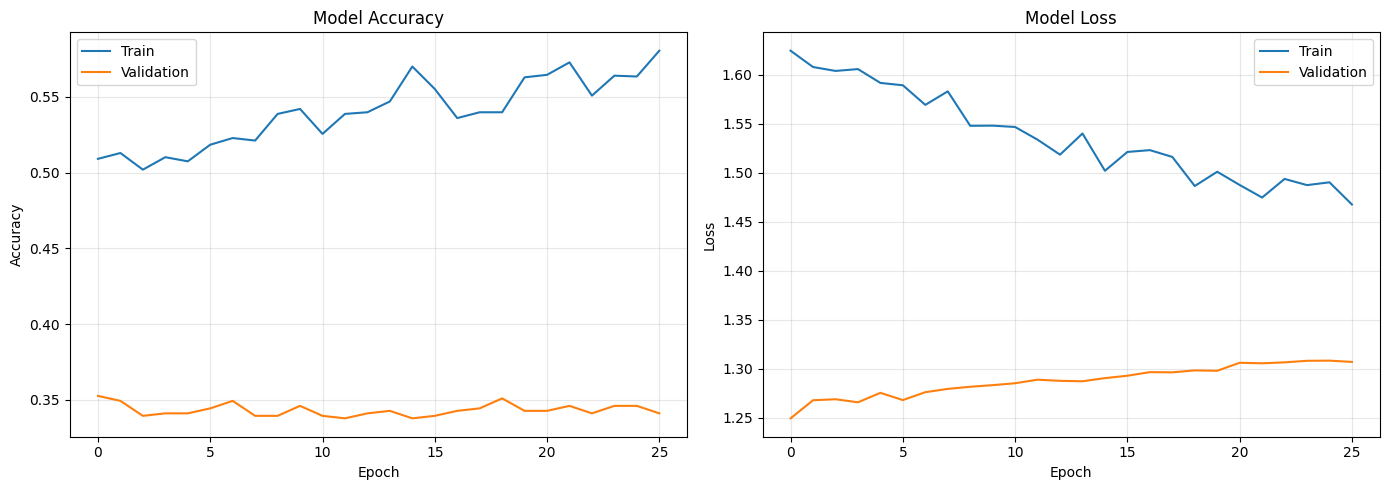

In [122]:
#Evaluate and Visulize

# Test set evaluation
metrics = model.evaluate(X_test, y_test, verbose=0)
test_loss = metrics[0]
test_acc = metrics[1]
test_precision = metrics[2]
test_recall = metrics[3]
test_f1 = f1_score(y_true, y_pred_classes, average='weighted')

print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")


# Visulization
plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()